In [10]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import tqdm
import functions as fc
from simul_ising import Metropolis  #  On importe la classe.
from tqdm import tqdm # Pour afficher où on est rendu dans la série de simulations.

data_folder = "data/" # Ne pas oublier le "/" après. Si en windows, c'est "\"

## Analyse des séries de simulation, enregistrées en format HDF5 
## (Cht'un grand fan, laissez-moi le temps de setupper le pipeline d'analyse comme du monde.)

### S'inspirer du simulateur Kuramoto.

1) Faire un dossier pour chaque série de simulations, quelle qu'elle soit. 
2) Enregistrer les multiples simuls pour aller chercher la variabilité de type (incertitude de type A) dans un même hdf5. 
3) Nouveau hdf5 pour nouvelle valeur de champ $h$ ou de tout autre paramètre, par exemple le pourcentage de spin up à l'état initial.
4) Faire un dossier différent pour chaque valeur de température ($\beta J$) essayée -> Permettra de calculer l'aire de la boucle d'hystérésis selon $\beta J$. 

## 1.1 Simulation exploratoire

L'algo Metro a convergé!
Temps d'exécution :  8.940260887145996


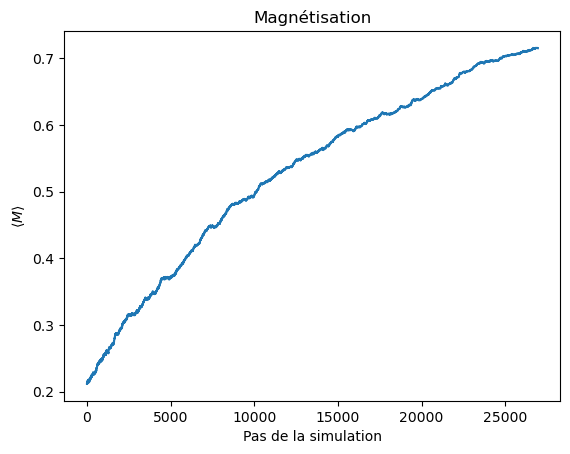

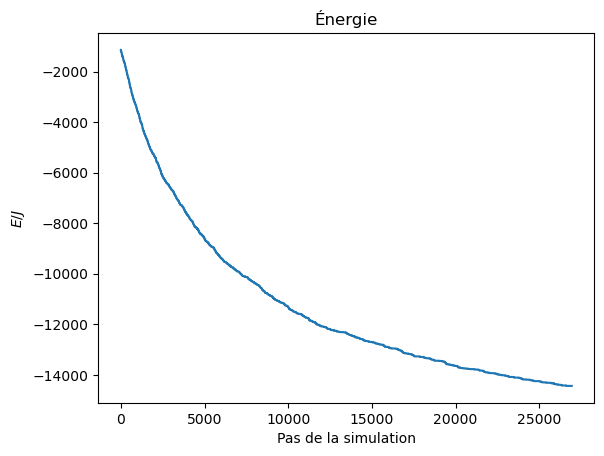

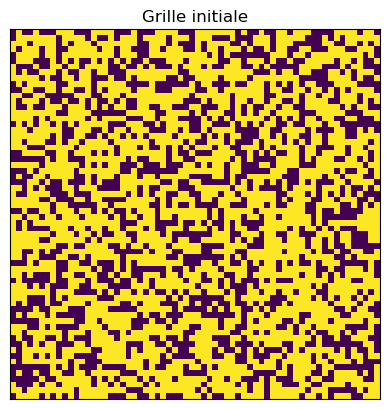

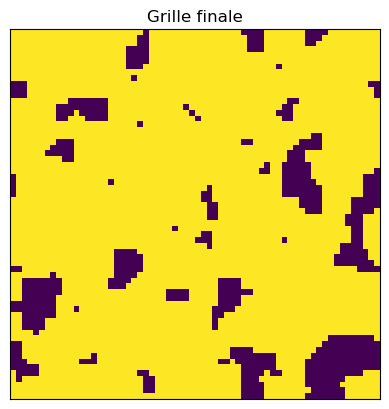

In [11]:
start_time = time.time()

# Créer une instance de la classe Metropolis avec les paramètres souhaités
metropolis = Metropolis(n_iter=0, lattice_size=64, magnetic_field=0.1, betaJ=1, pourcentage_up=0.6, convol="scipy", n_iter_max=int(1e9), delta_E_static=1e-4, delta_E_buffer=300, seed=42)

# Trouver l'état d'équilibre en utilisant la méthode "run"
lattices, spin_means, energy_list = metropolis.run()
step_algo = np.arange(0, len(spin_means), 1) # Itérations de la "descente" Metropolis

print("Temps d'exécution : ", time.time() - start_time)

plt.figure(1)
plt.plot(step_algo, spin_means)
plt.xlabel("Pas de la simulation")
plt.ylabel(r"$\langle M \rangle $")
plt.title("Magnétisation")

plt.figure(2)
plt.plot(step_algo, energy_list)
plt.xlabel("Pas de la simulation")
plt.ylabel(r"$E/J$")
plt.title("Énergie")

plt.figure(3)
plt.imshow(lattices[0], vmin=-1, vmax=1)
plt.title("Grille initiale")
plt.xticks([])
plt.yticks([])

plt.figure(4)
plt.imshow(lattices[-1], vmin=-1, vmax=1)
plt.title("Grille finale")
plt.xticks([])
plt.yticks([])

plt.show()

## 1.2 Simulations multiples

In [ ]:
def save_simulation_to_hdf5(filename, run_id, sim, lattices, spin_means, energy_list):
    with h5py.File(filename, 'a') as f:
        group_name = f"run_{run_id:04d}"
        if group_name in f:
            print(f"Warning: Group {group_name} already exists. Skipping save.")
            return  # On saute si le groupe d'enregistrement existe déjà. 

        grp = f.create_group(group_name)
        grp.create_dataset("initial_lattice", data=sim.lattice)
        grp.create_dataset("final_lattice", data=lattices[-1])
        grp.create_dataset("energy", data=energy_list)
        grp.create_dataset("magnetization", data=spin_means)

        grp.attrs["seed"] = sim.seed
        grp.attrs["betaJ"] = sim.betaJ
        grp.attrs["magnetic_field"] = sim.h
        grp.attrs["pourcentage_up"] = sim.up_perc
        grp.attrs["n_iter"] = sim.n_iter
        grp.attrs["convol"] = sim.convol

def run_batch_simulations(h_range, n_seeds, filename="data/results.h5"):
    betaJ = 1.0 # Couplage adimensionné (merci Sam).
    size = 64 # Un beau multiple de 2, comme on aime.
    pourcentage_up = 0.5 # On peut donner un avantage aux spins up/down, histoire d'aller chercher préférentiellement un point fixe stable!

    final_magnetizations = []
    std_magnetizations = []

    run_id = 0

    for h in tqdm(h_range, desc="Variation du champ magnétique"):
        mags = []
        for i in range(n_seeds):
            seed = np.random.randint(0, int(1e6))
            sim = Metropolis(
                n_iter=0,
                lattice_size=size,
                magnetic_field=h,
                betaJ=betaJ,
                pourcentage_up=pourcentage_up,
                convol="scipy",
                seed=seed
            )
            lattices, spin_means, energy_list = sim.run()
            save_simulation_to_hdf5(filename, run_id, sim, lattices, spin_means, energy_list)
            mags.append(spin_means[-1])
            run_id += 1

        final_magnetizations.append(np.mean(mags))
        std_magnetizations.append(np.std(mags))

    return h_range, final_magnetizations, std_magnetizations

if __name__ == "__main__": # Fancy pythonic attitude, même si mon coeur est au langage C.
    h_range = np.linspace(-0.2, 0.2, 2)
    print(h_range)
    h_vals, mag_means, mag_stds = run_batch_simulations(h_range, n_seeds=20)

    plt.figure()
    plt.plot(h_vals, mag_means, label="Magnétisation moyenne")
    plt.fill_between(h_vals,
                     np.array(mag_means) - np.array(mag_stds),
                     np.array(mag_means) + np.array(mag_stds),
                     alpha=0.3, label="Écart-type")
    
    plt.xlabel("Champ magnétique h")
    plt.ylabel("Magnétisation finale moyenne")
    plt.title("Effet du champ magnétique sur la magnétisation")
    plt.legend()
    plt.grid(True)
    plt.show()


# 2. Analyse des données de simulation

Clefs du fichier : ['run_0000', 'run_0001', 'run_0002', 'run_0003', 'run_0004', 'run_0005', 'run_0006', 'run_0007', 'run_0008', 'run_0009', 'run_0010', 'run_0011', 'run_0012', 'run_0013', 'run_0014', 'run_0015', 'run_0016', 'run_0017', 'run_0018', 'run_0019', 'run_0020', 'run_0021', 'run_0022', 'run_0023', 'run_0024', 'run_0025', 'run_0026', 'run_0027', 'run_0028', 'run_0029', 'run_0030', 'run_0031', 'run_0032', 'run_0033', 'run_0034', 'run_0035', 'run_0036', 'run_0037', 'run_0038', 'run_0039', 'run_0040', 'run_0041', 'run_0042', 'run_0043', 'run_0044', 'run_0045', 'run_0046', 'run_0047', 'run_0048', 'run_0049', 'run_0050', 'run_0051', 'run_0052', 'run_0053', 'run_0054', 'run_0055', 'run_0056', 'run_0057', 'run_0058', 'run_0059', 'run_0060', 'run_0061', 'run_0062', 'run_0063', 'run_0064', 'run_0065', 'run_0066', 'run_0067', 'run_0068', 'run_0069', 'run_0070', 'run_0071', 'run_0072', 'run_0073', 'run_0074', 'run_0075', 'run_0076', 'run_0077', 'run_0078', 'run_0079', 'run_0080', 'run_008

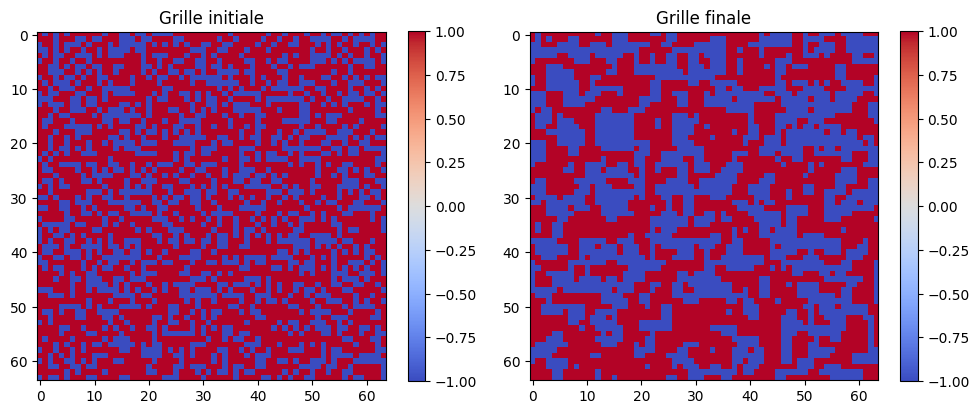

Énergie : [  -96.8   -96.8   -97.6 ... -7406.4 -7406.4 -7406.4]
Magnétisation : [0.18994141 0.18994141 0.18945312 ... 0.05957031 0.05957031 0.05957031]


In [14]:
dataset_name = "run_0001"  # Remplacez par le nom du groupe que vous voulez lire

data= {}

with h5py.File(data_folder + "results.h5", "r") as file:
    print("Clefs du fichier :", list(file.keys()))
    
    if dataset_name in file:
        group = file[dataset_name]
        data= group
        print(f"Attributs du groupe {dataset_name}:", dict(group.attrs))
        initial_lattice = group["initial_lattice"][:]
        final_lattice = group["final_lattice"][:]
        energy = group["energy"][:]
        magnetization = group["magnetization"][:]
        
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.title("Grille initiale")
        plt.imshow(initial_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.subplot(1, 2, 2)
        plt.title("Grille finale")
        plt.imshow(final_lattice, cmap="coolwarm", interpolation="nearest")
        plt.colorbar()
        plt.tight_layout()
        plt.show()
        print("Énergie :", energy)
        print("Magnétisation :", magnetization)
    else:
        print(f"Le groupe {dataset_name} n'existe pas dans le fichier.")